In [2]:
 
!pip install -U tensorflow==2.11 # Keras 2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 665.8 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 69.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 73.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.

In [4]:

!pip install git+https://github.com/sebastian-sz/efficientnet-lite-keras@main


  Cloning https://github.com/sebastian-sz/efficientnet-lite-keras (to revision main) to /tmp/pip-req-build-e26o5hsk
  Running command git clone --filter=blob:none --quiet https://github.com/sebastian-sz/efficientnet-lite-keras /tmp/pip-req-build-e26o5hsk
  Resolved https://github.com/sebastian-sz/efficientnet-lite-keras to commit 728def97857d8aa83535d9275a1834c7df2316e9
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import numpy as np
import pandas as pd
from glob import glob
import os
import pathlib
import tensorflow as tf
import keras

from keras.utils import  Sequence
from keras.models import Sequential
from tensorflow.keras.utils import img_to_array, load_img, to_categorical
#models
from efficientnet_lite import EfficientNetLiteB0, EfficientNetLiteB1, EfficientNetLiteB3

from sklearn.metrics import confusion_matrix
#preproces
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt

from collections import Counter
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score

import subprocess
from IPython.display import FileLink, display

from sklearn.utils.class_weight import compute_class_weight

from keras import backend as K

In [6]:
tf.__version__, keras.__version__

('2.11.0', '2.11.0')

# Data Load

In [7]:

imgs = glob(r'/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/*/*')
labels = [el.split('/')[5] for el in imgs ]
SIZE = 345 #414

# Visualisation

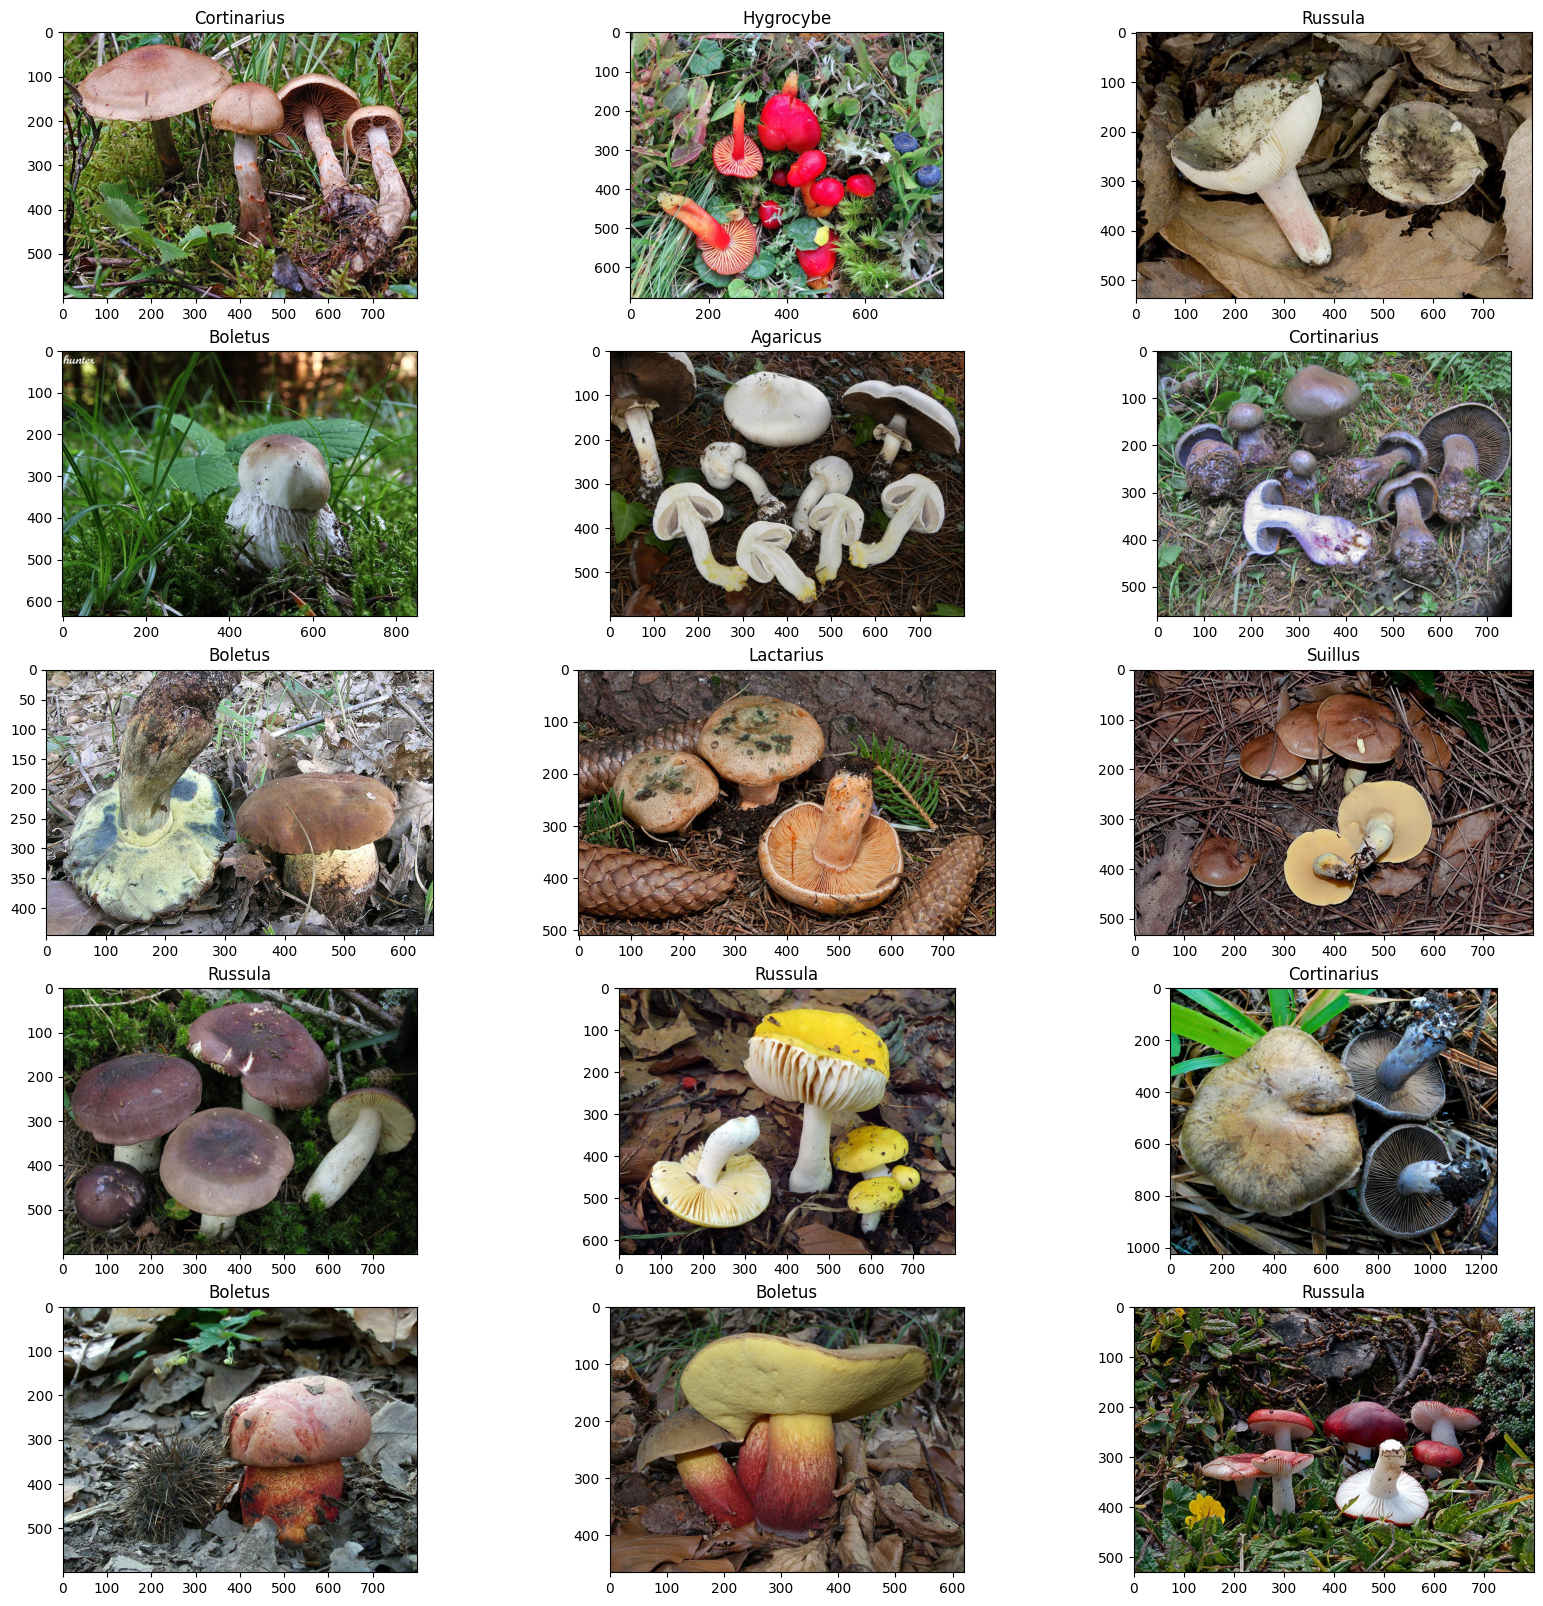

In [8]:

fig, ax = plt.subplots(5, 3, figsize=(20, 20))
fig.subplots_adjust()
im_list = np.random.choice(imgs, 15)
for axi, im in zip( ax.flat, im_list):
    axi.set_title(im.split('/')[5],)
    axi.imshow(plt.imread(im), )


## Class Distribution

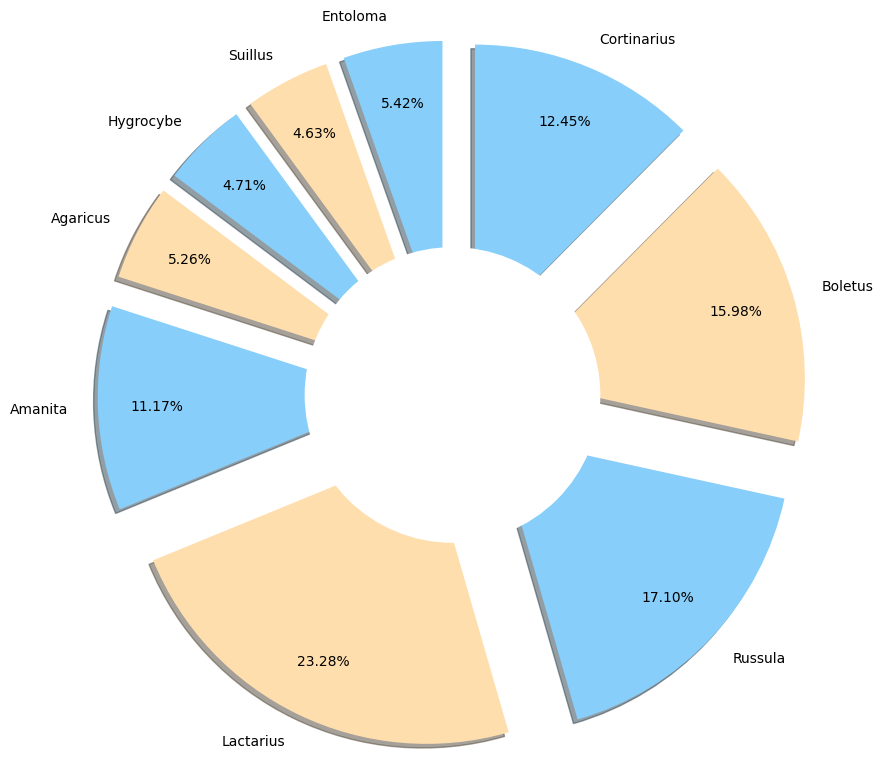

In [9]:

distribution_dict = {k:np.round(v*100/len(labels), 2) for k,v in Counter(labels).items()} 
distribution_dict = {k:np.round(v*100/len(labels), 2) for k,v in Counter(labels).items()} 
tab = {'lightskyblue': '#87CEFA', 'navajowhite': '#FFDEAD'}

plt.pie.DonutSize=9
plt.pie(distribution_dict.values(), labels=distribution_dict.keys(),radius=2, colors=tab, shadow=True, startangle=90, autopct='%1.2f%%',
       pctdistance=0.80, explode=[0.4 for el in range(9)])

hole = plt.Circle((0, 0), 1.0, facecolor='white')
plt.gcf().gca().add_artist(hole)
 
plt.show()

## Test Train Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.3, random_state=1, stratify=labels)
train = pd.DataFrame(list(zip(X_train,y_train)), columns =['X','y'])
test = pd.DataFrame(list(zip(X_test,y_test)), columns =['X','y'])

In [11]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [12]:



datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True, 
        brightness_range=(1.05, 0.9),)
valid_gen = ImageDataGenerator(rescale=1./255)

In [13]:
train_gen = datagen.flow_from_dataframe(train, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=True)
test_gen = valid_gen.flow_from_dataframe(test, x_col='X', y_col="y", target_size=(SIZE, SIZE), )

Found 4699 validated image filenames belonging to 9 classes.
Found 2015 validated image filenames belonging to 9 classes.


# Build up EFB1 model

In [12]:
def build_model(num_classes=9):
    base_model = EfficientNetLiteB1( #B3
        input_shape=(SIZE,SIZE, 3),
        include_top=False,
        pooling="avg",
        weights="imagenet"
    )

    base_model.trainable=True

    return tf.keras.Sequential([
        base_model,
        
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.6), #0.6 0.7
        tf.keras.layers.Dense(210, activation="silu", kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l1(0.033)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation="softmax", kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l1(0.033))
    ])

In [13]:

model = build_model()

17242680/17242680 [==============================] - 0s 0us/step


In [14]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetlite1 (Function  (None, 1280)             4189344   
 al)                                                             
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 210)               269010    
                                                                 
 batch_normalization_1 (Batc  (None, 210)              840       
 hNormalization)                                                 
                                                        

In [15]:

loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3, restore_best_weights=True, start_from_epoch=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=0, min_lr=1.0000e-08) #0



In [16]:

epoch = 10 # after more than 10 epoch tpu usually shut down 
history = model.fit(train_gen, validation_data=test_gen, epochs=epoch, callbacks=[early_stop, reduce_lr] )

Epoch 1/10
147/147 [==============================] - 544s 4s/step - loss: 58.4914 - accuracy: 0.4382 - val_loss: 10.3468 - val_accuracy: 0.5221 - lr: 0.0010
Epoch 2/10
147/147 [==============================] - 517s 4s/step - loss: 8.2671 - accuracy: 0.5729 - val_loss: 7.3249 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 3/10
147/147 [==============================] - 517s 4s/step - loss: 6.8836 - accuracy: 0.6401 - val_loss: 6.6450 - val_accuracy: 0.5950 - lr: 0.0010
Epoch 4/10
147/147 [==============================] - 524s 4s/step - loss: 6.7497 - accuracy: 0.6576 - val_loss: 6.7642 - val_accuracy: 0.6546 - lr: 0.0010
Epoch 5/10
147/147 [==============================] - 518s 4s/step - loss: 3.0709 - accuracy: 0.7561 - val_loss: 2.8460 - val_accuracy: 0.7613 - lr: 3.0000e-04
Epoch 6/10
147/147 [==============================] - 522s 4s/step - loss: 2.9607 - accuracy: 0.7693 - val_loss: 2.9566 - val_accuracy: 0.7940 - lr: 3.0000e-04
Epoch 7/10
147/147 [==============================] - 

In [18]:
def show_history(history):
    plt.figure(figsize=(18,8))

    plt.suptitle('Loss and Accuracy Plots', fontsize=18)

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.show()

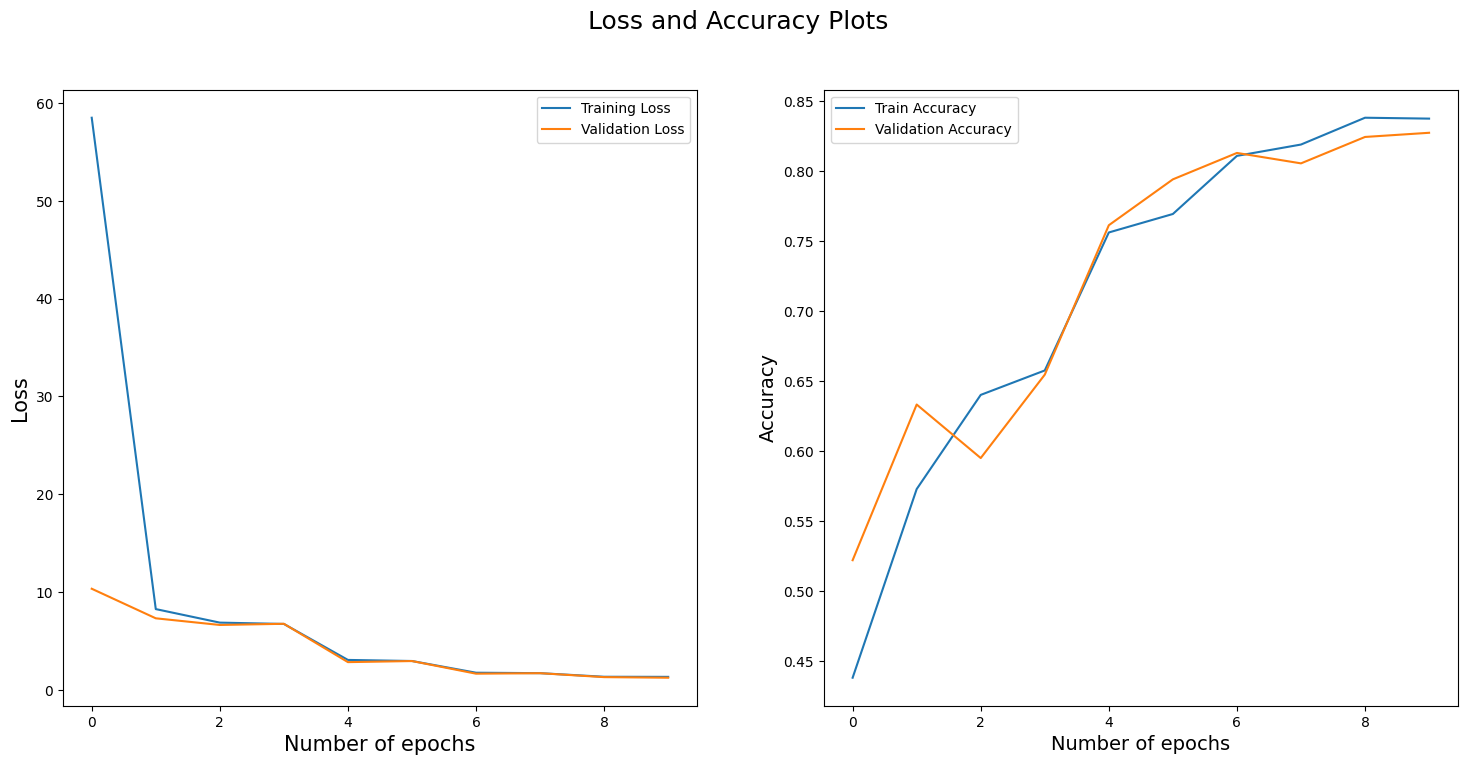

In [18]:
show_history(history)

In [48]:
model.save('mushroms_9_efb1_2212_t211_df.h5')

# Continue training

In [14]:
model = keras.models.load_model('/kaggle/input/m9_df/tensorflow2/m9_df/1/mushroms_9_efb1_2212_t211_df.h5')

In [15]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1.0000e-06)
 
model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3, restore_best_weights=True, start_from_epoch=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=0, min_lr=1.0000e-08) #0
epoch = 7
history = model.fit(train_gen, validation_data=test_gen, epochs=epoch, callbacks=[early_stop, reduce_lr] )

Epoch 1/7
147/147 [==============================] - 532s 4s/step - loss: 1.1967 - accuracy: 0.8442 - val_loss: 1.1248 - val_accuracy: 0.8263 - lr: 1.0000e-06
Epoch 2/7
147/147 [==============================] - 520s 4s/step - loss: 1.1897 - accuracy: 0.8393 - val_loss: 1.1213 - val_accuracy: 0.8263 - lr: 1.0000e-06
Epoch 3/7
147/147 [==============================] - 518s 4s/step - loss: 1.1842 - accuracy: 0.8398 - val_loss: 1.1185 - val_accuracy: 0.8263 - lr: 1.0000e-06
Epoch 4/7
147/147 [==============================] - 519s 4s/step - loss: 1.1819 - accuracy: 0.8478 - val_loss: 1.1194 - val_accuracy: 0.8288 - lr: 1.0000e-06
Epoch 5/7
147/147 [==============================] - 514s 3s/step - loss: 1.1807 - accuracy: 0.8468 - val_loss: 1.1129 - val_accuracy: 0.8268 - lr: 3.0000e-07
Epoch 6/7
147/147 [==============================] - 518s 4s/step - loss: 1.1819 - accuracy: 0.8351 - val_loss: 1.1120 - val_accuracy: 0.8263 - lr: 3.0000e-07
Epoch 7/7
147/147 [===========================

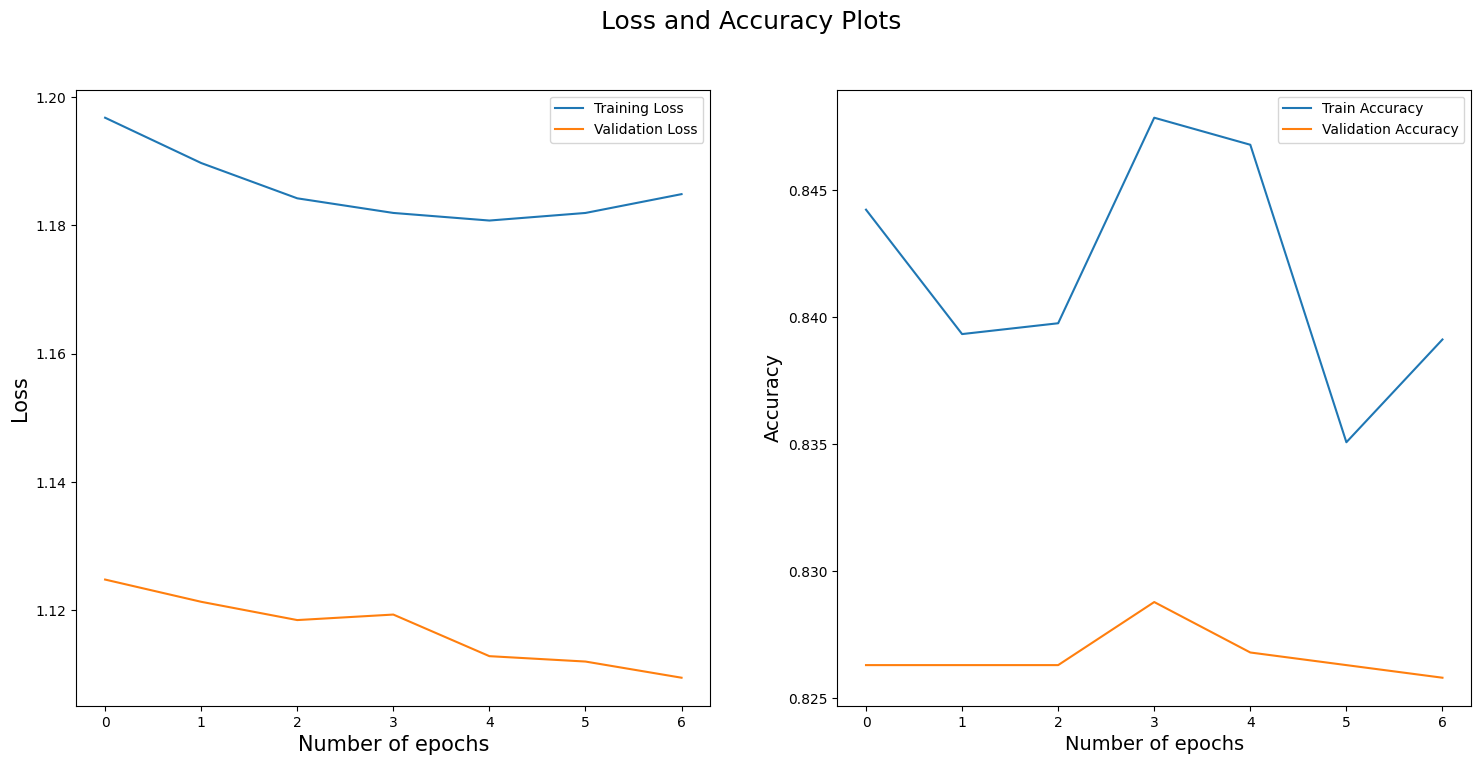

In [19]:
show_history(history)

In [20]:
model.save('mushroms_9_efb1_2312_t211_df_p2.h5')

# Metrics

In [21]:
model.evaluate(test_gen),
model.evaluate(train_gen);

147/147 [==============================] - 193s 1s/step - loss: 0.9475 - accuracy: 0.8987
